# Setup,Mount and Download Dataset


In [ ]:
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Configure Kaggle
# Ensure 'kaggle.json' is in the main folder of your Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

# 3. Download the Dataset (Using a popular Brain Tumor MRI dataset as example)
# This downloads it to the temporary Colab runtime, not your Drive (saves space)
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# 4. Unzip the dataset
# !unzip -q brain-tumor-mri-dataset.zip -d /content/dataset

print("Dataset downloaded and unzipped successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already exists.


## Imports and Configurations


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10  # Adjust as needed
dataset_dir = '/content/dataset/Training' # Path to unzipped data

## Data Preprocessing


In [ ]:
# 1. Setup Generators
# Augmentation for training to prevent overfitting
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # We'll use 20% of training data for validation
)

# 2. Load Data
print("Loading Training Data...")
train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Loading Validation Data...")
val_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print class mappings
print(f"Class Mappings: {train_ds.class_indices}")

Loading Data (needed for class labels)...
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Class Mappings: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Building the Model


In [ ]:
# 1. Load Base Model (Pre-trained on ImageNet)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Freeze the base model (so we don't destroy pre-trained weights)
base_model.trainable = True

# 3. Add Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Dropout to reduce overfitting
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 4 classes: Glioma, Meningioma, Pituitary, No Tumor

# 4. Final Model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

AttributeError: module 'keras' has no attribute 'KerasTensor'

## Training the Model


In [ ]:
# Define where to save the model in Google Drive
checkpoint_path = "/content/drive/MyDrive/tumor_classifier_model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    )
]

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

⏭️ Skipping training (Pre-trained model loaded).


Generating predictions for validation set...
Found 1141 images belonging to 4 classes.


Generating predictions for validation set...
Found 1141 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Generating predictions for validation set...
Found 1141 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step


Generating predictions for validation set...
Found 1141 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step


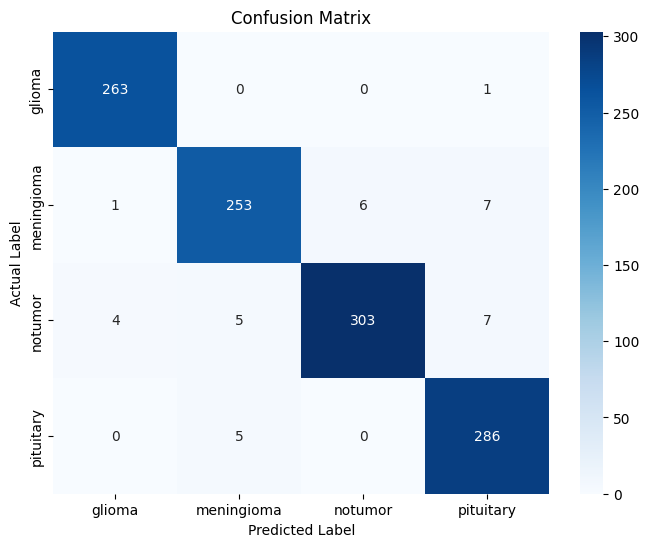


Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       264
  meningioma       0.96      0.95      0.95       267
     notumor       0.98      0.95      0.96       319
   pituitary       0.95      0.98      0.97       291

    accuracy                           0.97      1141
   macro avg       0.97      0.97      0.97      1141
weighted avg       0.97      0.97      0.97      1141



In [ ]:
# Evaluation (Confusion Matrix)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define constants again to avoid NameError
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Get predictions for the entire validation set
print("Generating predictions for validation set...")
# shuffle=False is critical here so predictions match the true labels order
val_ds_eval = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Predict
Y_pred = model.predict(val_ds_eval)
y_pred = np.argmax(Y_pred, axis=1)  # Convert probabilities to class index

# True labels
y_true = val_ds_eval.classes

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_ds_eval.class_indices.keys())

# 3. Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Print detailed Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Visualize the Performance


In [ ]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ℹ️ Training history is not available (Training was skipped).


## Testing Custom Images


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


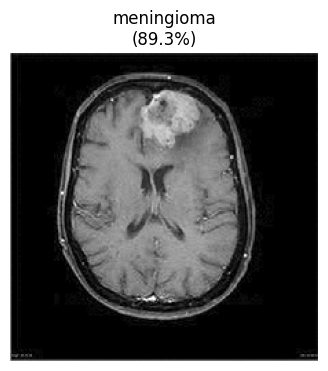

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


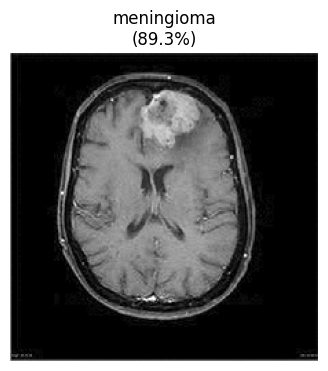

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


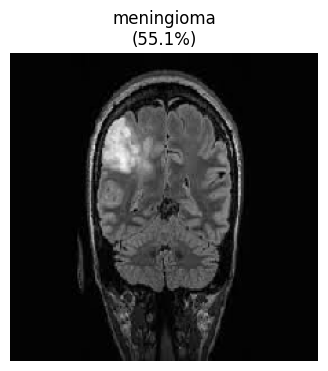

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


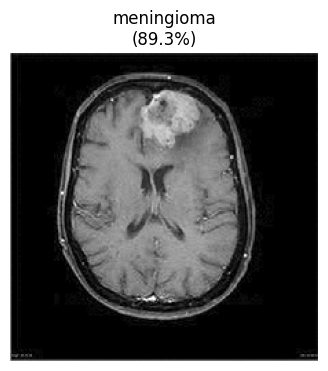

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


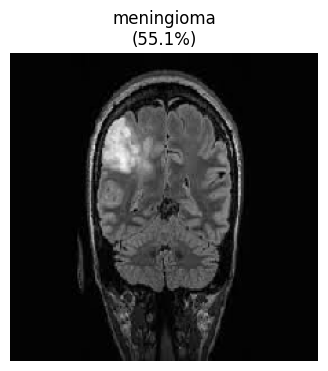

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


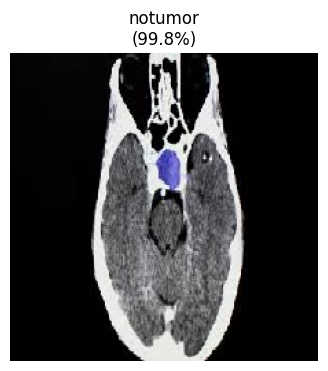

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


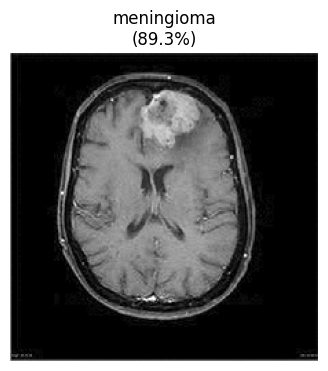

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


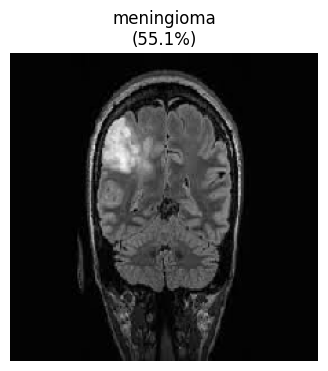

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


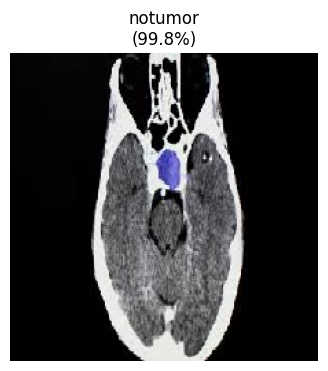

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


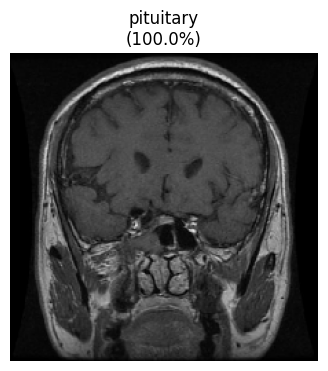

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


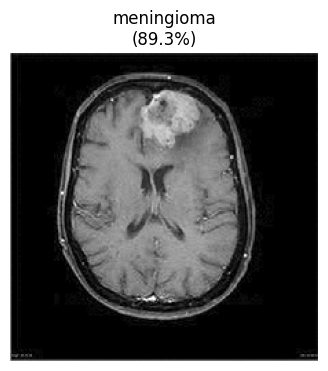

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


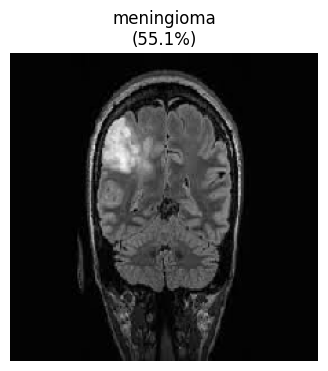

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


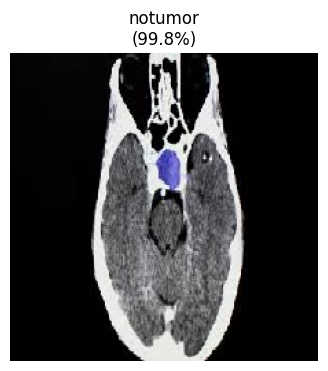

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


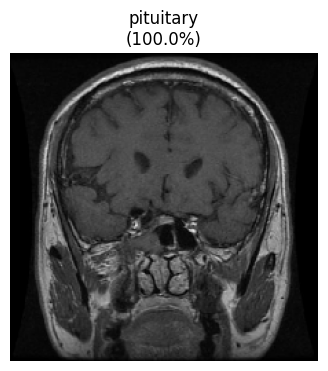

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


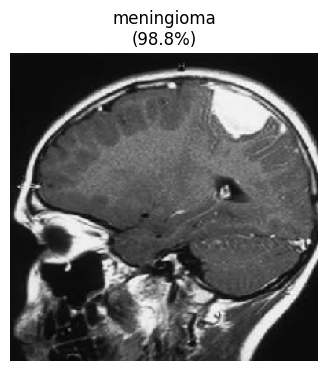

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


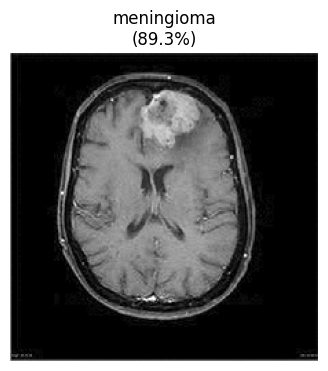

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


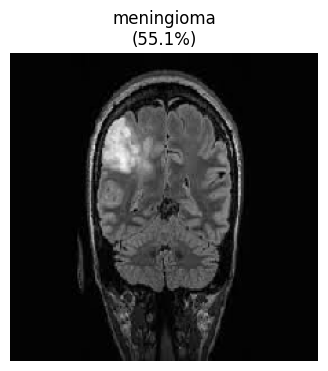

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


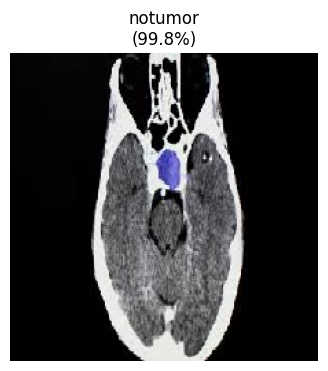

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


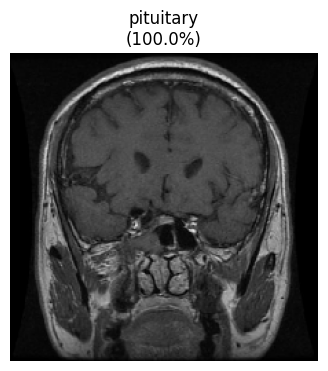

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


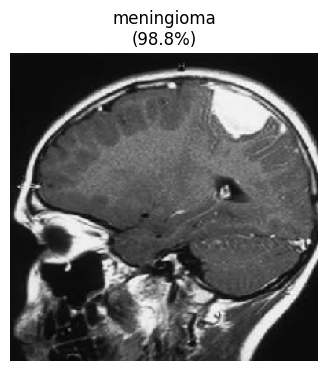

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


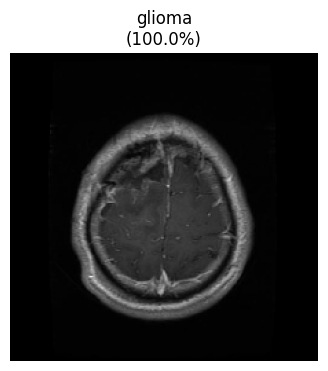

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Found 7 images. Analyzing now...

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


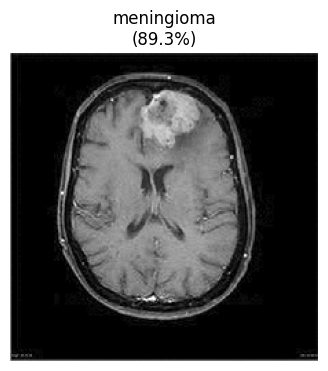

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


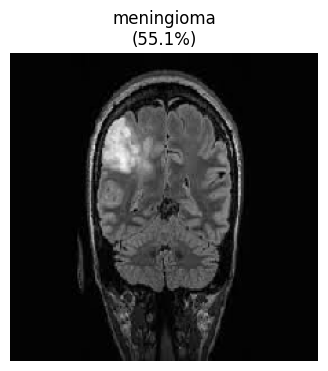

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


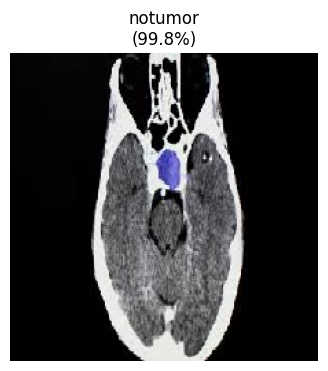

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


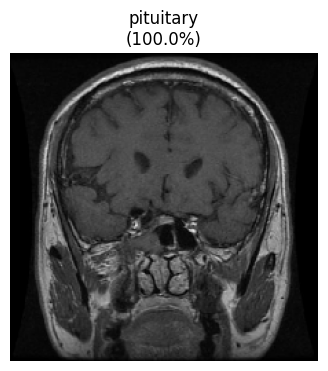

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


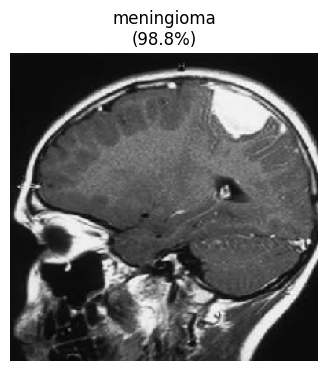

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


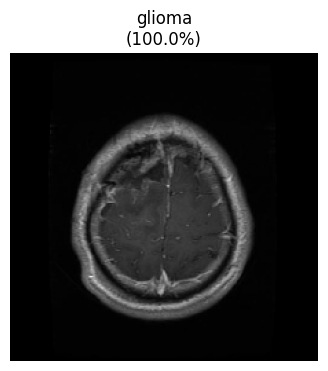

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


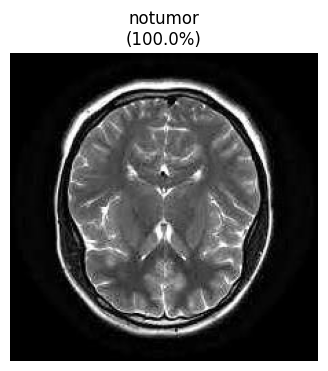

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 1. Path to your folder (Dump all your images here)
test_folder_path = '/content/drive/MyDrive/Test_Images' 

def predict_single_image(img_path):
    try:
        # Load image
        img = image.load_img(img_path, target_size=(224, 224))
        
        # Convert to array
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # --- CRITICAL FIX: DO NOT DIVIDE BY 255 ---
        # We trained on 0-255, so we predict on 0-255
        
        # Predict
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction)
        
        # Get Label
        class_map = {v: k for k, v in train_ds.class_indices.items()}
        predicted_label = class_map[class_idx]
        
        # Display
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"{predicted_label}\n({confidence*100:.1f}%)")
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# 2. Main Loop
if os.path.exists(test_folder_path):
    files = os.listdir(test_folder_path)
    # Filter only image files
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print("Folder is empty! Please upload images.")
    else:
        print(f"Found {len(image_files)} images. Analyzing now...\n")
        for filename in image_files:
            full_path = os.path.join(test_folder_path, filename)
            predict_single_image(full_path)
else:
    print(f"Folder not found: {test_folder_path}")

In [ ]:
# import os
# import shutil

# # 1. Define the root directory to search (Colab default)
# root_search_path = '/content/'
# dest_folder = '/content/drive/MyDrive/Test_Images'

# # Ensure destination exists
# if not os.path.exists(dest_folder):
#     os.makedirs(dest_folder)

# # 2. Function to find one image for a specific tumor type
# def find_and_copy_image(tumor_type):
#     print(f"Searching for a {tumor_type} image...")
#     for root, dirs, files in os.walk(root_search_path):
#         # Look for a folder that matches the tumor type (case insensitive)
#         if tumor_type.lower() in root.lower() and 'testing' in root.lower():
#             for file in files:
#                 if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#                     # Found one! Copy it.
#                     src_path = os.path.join(root, file)
#                     new_name = f"VALIDATION_{tumor_type.upper()}.jpg"
#                     dest_path = os.path.join(dest_folder, new_name)
                    
#                     shutil.copy(src_path, dest_path)
#                     print(f"✅ Found and copied: {new_name}")
#                     return # Stop after finding one
#     print(f"❌ Could not find an image for {tumor_type}")

# # 3. Run the search for all 3 types
# print("Starting Auto-Search for Validation Images...\n")
# find_and_copy_image('pituitary')
# find_and_copy_image('meningioma')
# find_and_copy_image('glioma')
# find_and_copy_image('notumor') 

# print("\nDone! Check your 'Test_Images' folder in Drive.")

# Completely new dataset testing


In [ ]:
# Cell 11: Download External Validation Set (Navoneel's Dataset)
import os

# 1. Download
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/external_test

# 2. Unzip to a specific folder
# !unzip -q /content/external_test/brain-mri-images-for-brain-tumor-detection.zip -d /content/external_test/data

print("\nExternal dataset ready at: /content/external_test/data")

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/external_test/data/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Cell 12: External Validation Logic
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define paths
base_path = '/content/external_test/data'
yes_path = os.path.join(base_path, 'yes')
no_path = os.path.join(base_path, 'no')

# Counters
correct_yes = 0
total_yes = 0
correct_no = 0
total_no = 0

# Helper function to predict
def get_pred_label(img_path):
    try:
        # Load and process (NO rescaling, just like training)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict
        prediction = model.predict(img_array, verbose=0)
        class_idx = np.argmax(prediction)
        
        # Map index to name
        class_map = {v: k for k, v in train_ds.class_indices.items()}
        return class_map[class_idx]
    except:
        return None

print("Starting External Validation...")
print("-" * 30)

# 1. Test "NO" (Healthy) images
print(f"Testing 'NO' folder (Expectation: 'notumor')...")
if os.path.exists(no_path):
    for f in os.listdir(no_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_no += 1
            pred = get_pred_label(os.path.join(no_path, f))
            if pred == 'notumor':
                correct_no += 1

# 2. Test "YES" (Tumor) images
print(f"Testing 'YES' folder (Expectation: 'glioma', 'meningioma', or 'pituitary')...")
if os.path.exists(yes_path):
    for f in os.listdir(yes_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_yes += 1
            pred = get_pred_label(os.path.join(yes_path, f))
            # If it predicts ANY tumor type, we count it as correct
            if pred in ['glioma', 'meningioma', 'pituitary']:
                correct_yes += 1

# --- Final Report ---
print("\n" + "="*30)
print("EXTERNAL VALIDATION REPORT")
print("="*30)

acc_no = (correct_no / total_no) * 100 if total_no > 0 else 0
acc_yes = (correct_yes / total_yes) * 100 if total_yes > 0 else 0
total_acc = ((correct_no + correct_yes) / (total_no + total_yes)) * 100

print(f"Healthy Images Tested: {total_no}")
print(f"Correctly Identified as Healthy: {correct_no}")
print(f"Specificity (Healthy Accuracy): {acc_no:.2f}%")
print("-" * 20)
print(f"Tumor Images Tested: {total_yes}")
print(f"Correctly Identified as Tumor: {correct_yes}")
print(f"Sensitivity (Tumor Accuracy): {acc_yes:.2f}%")
print("="*30)
print(f"OVERALL EXTERNAL ACCURACY: {total_acc:.2f}%")

Starting External Validation...
------------------------------
Testing 'NO' folder (Expectation: 'notumor')...
Testing 'YES' folder (Expectation: 'glioma', 'meningioma', or 'pituitary')...

EXTERNAL VALIDATION REPORT
Healthy Images Tested: 98
Correctly Identified as Healthy: 98
Specificity (Healthy Accuracy): 100.00%
--------------------
Tumor Images Tested: 155
Correctly Identified as Tumor: 89
Sensitivity (Tumor Accuracy): 57.42%
OVERALL EXTERNAL ACCURACY: 73.91%


# Saving to Google Drive


In [ ]:
# # Save the model to your Google Drive
# model_path = '/content/drive/MyDrive/best_tumor_classifier_v1.keras'
# model.save(model_path)

# print(f"Model saved successfully to: {model_path}")

Model saved successfully to: /content/drive/MyDrive/best_tumor_classifier_v1.keras
